In [1]:
import networkx as nx
import pandas as pd

In [2]:
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

Agrego a la red data del género de los delfines.

In [3]:
Red_delfines = nx.read_gml('./data/dolphins.gml')
dolphins_gender = abrir_txt('./data/dolphinsGender.txt')
gender_dict = dict(dolphins_gender)
nx.set_node_attributes(Red_delfines, gender_dict, 'gender')

In [4]:
nodos = dict(Red_delfines.nodes(data = True))
masculinos = []
femeninos = []
sin_genero = []
for nodo in nodos:
    if gender_dict[nodo] == 'm':
        masculinos.append(nodo)
    if gender_dict[nodo] == 'f':
        femeninos.append(nodo)
    if gender_dict[nodo] == 'NA':
        sin_genero.append(nodo)

In [5]:
%store masculinos
%store femeninos
%store sin_genero
%store gender_dict

Stored 'masculinos' (list)
Stored 'femeninos' (list)
Stored 'sin_genero' (list)
Stored 'gender_dict' (dict)


Queremos ver la relación entre genéro y las comunidades halladas. 

In [6]:
print(f'Tenemos {round(len(masculinos) / Red_delfines.number_of_nodes() * 100, 2)}% de delfines masculinos, {round(len(femeninos) / Red_delfines.number_of_nodes() * 100, 2)}% de hembras y {round(len(sin_genero) / Red_delfines.number_of_nodes() * 100, 2)}% sin género.')

Tenemos 54.84% de delfines masculinos, 38.71% de hembras y 6.45% sin género.


Queremos ver si las comunidades halladas tienen la distribución de grado que se esperaría al hacer comunidades al azar (similar a las de la red total) o si tienen prevalencia de algún género. 

In [7]:
%store -r particiones

In [8]:
from collections import defaultdict
particiones_con_genero = {}

for metodo in particiones.keys():
    particiones_con_genero[metodo] = defaultdict(list)
    for d in (particiones[metodo], gender_dict): # you can list as many input dicts as you want here
        for key, value in d.items():
            particiones_con_genero[metodo][key].append(value)

In [9]:
dicc_genero_metodo_comunidad = {}

for metodo in particiones_con_genero:
    dicc_genero_metodo_comunidad[metodo] = {}
    cantidad_de_comunidades = max(particiones_con_genero[metodo].values(), key=lambda x: x[0])[0]
    for comunidad in range(0, cantidad_de_comunidades):
        dicc_genero_metodo_comunidad[metodo][comunidad] = {}
        dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'] = 0
        dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres'] = 0
        
        for delfin in particiones_con_genero[metodo]:
            if particiones_con_genero[metodo][delfin][0] == comunidad and particiones_con_genero[metodo][delfin][1] == 'm':
                dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'] += 1
            if particiones_con_genero[metodo][delfin][0] == comunidad and particiones_con_genero[metodo][delfin][1] == 'f':
                dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres'] += 1
                

In [10]:
import numpy as np

df_genero = pd.concat({k: pd.DataFrame(v) for k, v in dicc_genero_metodo_comunidad.items()}).transpose()
cols = df_genero.columns
for col in cols:
    df_genero[col] = df_genero[col].apply(lambda x: int(x) if x == x else "Nan")
df_genero

Edge_bet         Fast_greedy         Infomap         Louvline        
   Hombres Mujeres     Hombres Mujeres Hombres Mujeres  Hombres Mujeres
0        5       2           8      15       3       2        7       2
1        3      16           9       5       4      13       14       3
2        9       3          17       2       9       3        9       5
3       16       3         Nan     Nan       8       0      Nan     Nan
4      Nan     Nan         Nan     Nan      10       2      Nan     Nan

In [11]:
import scipy.stats as stats
generos_red = [len(masculinos), len(femeninos)]

fisher_dict = {}

for metodo in dicc_genero_metodo_comunidad:
    fisher_dict[metodo] = {}
    for comunidad in dicc_genero_metodo_comunidad[metodo]:
        generos_comu = [dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'], dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres']]
        _, pvalue = stats.fisher_exact([generos_comu, generos_red]) 
        fisher_dict[metodo][comunidad] = pvalue

In [12]:
df_fisher = pd.DataFrame.from_dict(fisher_dict)
df_fisher.index.name = 'Comunidad'
df_fisher.round(3)

,Edge_bet,Fast_greedy,Louvline,Infomap
Comunidad,,,,
0,0.693,0.083,0.465,1.000
1,0.001,0.769,0.090,0.014
2,0.347,0.014,0.769,0.347
3,0.054,NaN,NaN,0.043
4,NaN,NaN,NaN,0.188


Las comunidades que presentan un valor del Test de Fischer cercano a uno son grupos que tienen una distribución de género similar a la de la red total. Por ejemplo, la _comunidad 0_ de Infomap que tiene 7 delfines macho y 2 hembra tiene una distribución igual a la red real, mientras que la comunidad 1 de Edge Betweeness, con 3 hombres y 16 mujeres, tiene bastante mayor porcentaje de mujeres que lo esperado.

En general la mayoría de las particiones tiene predominancia de un género, lo que nos lleva a concluir que los delfines tienen cierta tendencia a relacionarse con delfines de su mismo género. Sin embargo, hay grupos donde se respeta la proporción esperada. Cabría analizar, consiguiendo por ejemplo la edad de los delfines, saber si esto se corresponde a la edad de reproducción de los mismos o al cuidado de los más chicos. 

Queremos realizar algunas hipótesis sobre el comportamiento de los delfines para preguntarnos si se llevan entre distintos géneros. 

En primer lugar queremos ver si los grupos que tienen mayor porcentaje de mujeres u hombres para cada método corresponden siempre a los mismos delfines. Para eso vamos a analizar el caso de la comunidad 1 con el método Edge Betweennes y la comunidad 1 con el método Infomap.

In [13]:
delfines_por_comunidad = {}

for metodo in particiones:
    delfines_por_comunidad[metodo] = {}
    for delfin, comunidad in particiones[metodo].items():
        delfines_por_comunidad[metodo].setdefault(comunidad, set())
        delfines_por_comunidad[metodo][comunidad].add(delfin)
    

In [14]:
mujeres_intersection = 0
intersection = delfines_por_comunidad["Edge_bet"][1].intersection(delfines_por_comunidad["Infomap"][1])
for delfin in intersection:
    if gender_dict[delfin] == 'f':
        mujeres_intersection += 1 
print(f'La comunidad 1 de Edge Betweennes (con 16 delfines mujeres) y la comunidad 1 de Infomap comparten a {mujeres_intersection} delfines mujeres')  

La comunidad 1 de Edge Betweennes (con 16 delfines mujeres) y la comunidad 1 de Infomap comparten a 13 delfines mujeres


Ahora vemos si los grupos que respetan la proporción de género, en mayor medida, también corresponden a los mismos delfines.

In [15]:
comunidades_proporcionadas = []
for metodo in fisher_dict:
    for comunidad in fisher_dict[metodo]:
        if fisher_dict[metodo][comunidad] > 0.5:
            comunidades_proporcionadas.append((metodo, comunidad))    

In [16]:
comunidades_proporcionadas

[('Edge_bet', 0), ('Fast_greedy', 1), ('Louvline', 2), ('Infomap', 0)]

In [17]:
from itertools import combinations

intersecciones_proporcionadas = {}

for m_1, m_2 in list(combinations(comunidades_proporcionadas, 2)):
    par = (m_1, m_2)
    delfines_1 = delfines_por_comunidad[m_1[0]][m_1[1]]
    delfines_2 = delfines_por_comunidad[m_2[0]][m_2[1]]
    intersecciones_proporcionadas[par] = len(delfines_1.intersection(delfines_2))

In [18]:
intersecciones_proporcionadas

{(('Edge_bet', 0), ('Fast_greedy', 1)): 0,
 (('Edge_bet', 0), ('Louvline', 2)): 0,
 (('Edge_bet', 0), ('Infomap', 0)): 5,
 (('Fast_greedy', 1), ('Louvline', 2)): 15,
 (('Fast_greedy', 1), ('Infomap', 0)): 0,
 (('Louvline', 2), ('Infomap', 0)): 0}

In [38]:
shape_dict = {}
for nodo in Red_delfines.nodes(): 
    if gender_dict[nodo] == 'm':
        shape_dict[nodo] = 's' 
    if gender_dict[nodo] == 'f':
        shape_dict[nodo] = '*' 
    if gender_dict[nodo] == 'NA':
        shape_dict[nodo] = '^'
nx.set_node_attributes(Red_delfines, shape_dict, 'shape')

shapes = set([nodo[1]['shape'] for nodo in Red_delfines.nodes(data = True)])

posiciones = nx.kamada_kawai_layout(Red_delfines)

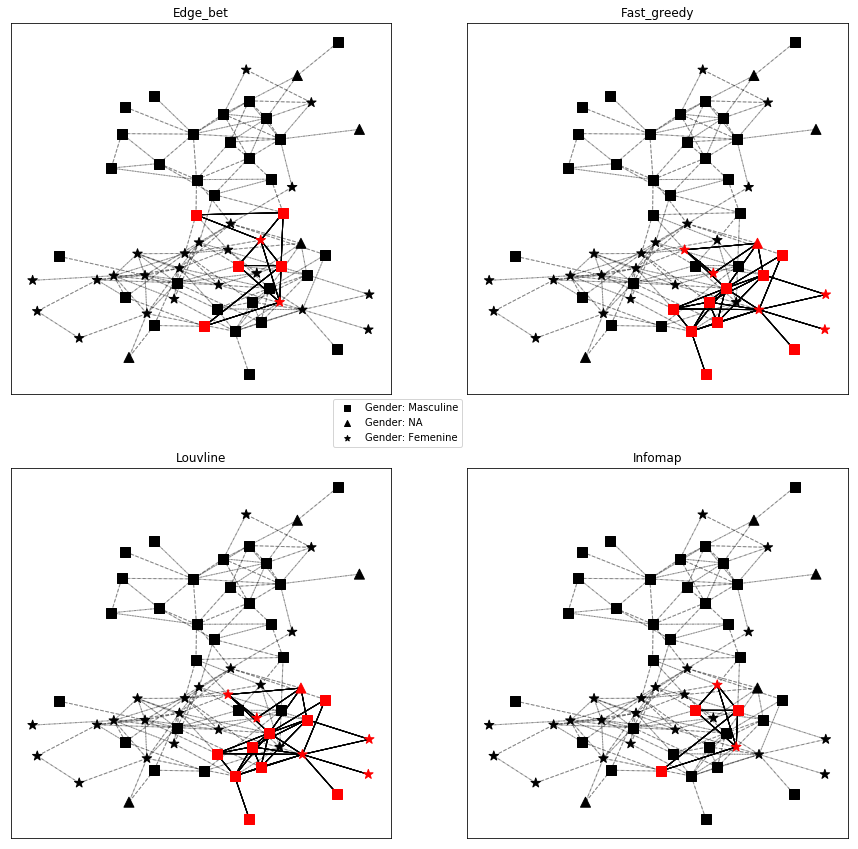

In [92]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for i,metodo in enumerate(particiones):
    particion = particiones[metodo]
    comunidad_de_interes = [item[1] for item in comunidades_proporcionadas if item[0] == metodo][0]

    node_color_dict = {}
    edge_list_comunidad = []
    edge_list_resto = []
    for node in Red_delfines.nodes():
        if particion[node] == comunidad_de_interes:
            node_color_dict[node] = 'red'
            for edge in Red_delfines.edges(node):
                if edge[1] in delfines_por_comunidad[metodo][comunidad_de_interes]:
                    edge_list_comunidad.append(edge)
                else: 
                    edge_list_resto.append(edge)
        else:
            node_color_dict[node] = 'black'
            edge_list_resto.extend(list(Red_delfines.edges(node)))
            
    for aShape in shapes: 
        
        node_list = [sNode for sNode, attr in Red_delfines.nodes(data = True) if attr['shape'] == aShape]
        node_color = [node_color_dict[sNode] for sNode in node_list]
        nx.draw_networkx_edges(Red_delfines, posiciones, edgelist = list(edge_list_comunidad), alpha = 1., ax = axs[i])
        nx.draw_networkx_edges(Red_delfines, posiciones, edgelist = edge_list_resto, alpha = 0.1, ax = axs[i], style = 'dashed')
        nx.draw_networkx_nodes(Red_delfines, node_size= 100, ax = axs[i], node_color = node_color,pos=posiciones, node_shape = aShape,  nodelist = node_list)
    
    axs[i].set_title(metodo)
    
    label = {'s': 'Masculine', '*':'Femenine', '^':"NA"}
for aShape in shapes:
    plt.scatter([],[], c = 'black', marker = aShape, label='Gender: {}'.format(label[aShape]))

plt.legend(bbox_to_anchor=(0, 1.2))
plt.show()